# 필요 모듈 설치

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install folium matplotlib mapclassify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 라이브러리 로드

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import wkt

import seaborn as sns
import folium
import matplotlib.pyplot as plt

import unicodedata

In [ ]:
src_path = '/content/drive/MyDrive/sk쉴더스/프로젝트1/[5조]_모듈프로젝트1_소스코드/data/'
plt.rcParams['font.family'] = 'NanumGothic'

# 데이터 로드

**1. 교통사고 데이터**

- 데이터 설명
  - 2021년 서울특별시에서 일어난 모든 교통사고 데이터
- 데이터 수집 방법
  - GIS 공간분석 페이지를 셀레니움으로 크롤링 ([TAAS 교통사고분석시스템](http://taas.koroad.or.kr/gis/mcm/mcl/initMap.do?menuId=GIS_GMP_STS_RSN))

In [ ]:
accident = pd.read_csv(src_path + 'accident_info.csv')
accident.head(2)

,사고경위,사고경중,대상,노면상태,사고유형,요일,시간,주야간구분,피해차종,가해차종,도로형태,X좌표,Y좌표,geometry
0,신호위반,중상사고,차대차,포장 - 건조,측면충돌,금요일,00시,야간,원동기,승용,교차로 - 교차로안,948902,1955807,POINT (948902 1955807)
1,신호위반,중상사고,차대차,포장 - 건조,기타,금요일,00시,야간,승합,이륜,단일로 - 기타,947601,1946291,POINT (947601 1946291)


- 격자 DataFrame을 GeoDataFrame으로 구성
  - 격자별로 시각화하기 위해 필요하다


In [ ]:
accident['geometry'] = accident['geometry'].apply(wkt.loads)
geo_accident = gpd.GeoDataFrame(accident, crs='epsg:5179')

**2. 격자 데이터**

- 데이터 설명
  - 서울특별시를 $500m \times 500m$ 격자로 나눈 후 격자별 특성을 나타낸 데이터
- 데이터 수집 방법
  - $500m$ 격자별 총 인구 수 (국토정보플랫폼)에 시설물 현황 데이터를 매칭


In [ ]:
grids = pd.read_csv(src_path + 'grid_feature.csv')
grids.head(2)

,gid,초등학교수,중학교수,고등학교수,어린이보호구역수,교차로,보행자작동신호기,횡단보도,음향신호기,안전표지,신호등,잔여시간표시기,도로면적,총인구수,단란주점,유흥주점,일반음식점,교통사고수,geometry,gu
0,다사58a48a,0,0,0,1,0.0,0.0,44.0,0.0,133.0,12.0,0.0,49829.303222,6085.0,0,0,24,20,"POLYGON ((958000 1948000, 958000 1948500, 9585...",강남구
1,다사58b48a,1,0,1,1,2.0,4.0,40.0,0.0,159.0,4.0,0.0,64451.237626,3446.0,0,0,3,18,"POLYGON ((958500 1948000, 958500 1948500, 9590...",강남구


In [ ]:
grids['geometry'] = grids['geometry'].apply(wkt.loads)
geo_grids = gpd.GeoDataFrame(grids, crs='epsg:5179')

# 데이터 시각화

## 서울시 격자별 교통사고 시각화

In [ ]:
center = [37.566535, 126.9779692]
m = folium.Map(location=center, 
               zoom_start=11,
               zoom_control=False,
               scrollWheelZoom=False,
               dragging=False,
               tiles='CartoDB positron')

c = folium.Choropleth(geo_data = geo_grids,                                 # 위치 데이터
                    data=geo_grids[['gid', '교통사고수']],                  # 데이터
                    columns=['gid', '교통사고수'],
                    fill_color='RdPu',
                    key_on='properties.gid',                                # 격자번호 기준
                    highlight=True,
                    fill_opacity=0.85, 
                    line_opacity=0,
                    legend_name='교통사고수'   
                    ).add_to(m)
c.geojson.add_child(folium.features.GeoJsonTooltip(['gid', '교통사고수']))  # 구역 이름 표시
m

Output hidden; open in https://colab.research.google.com to view.

## 상위 5개 격자 위치 시각화

In [ ]:
top5_acc_grid = geo_grids.sort_values(by='교통사고수', ascending=False).head(5)
top5_acc_grid

,gid,초등학교수,중학교수,고등학교수,어린이보호구역수,교차로,보행자작동신호기,횡단보도,음향신호기,안전표지,신호등,잔여시간표시기,도로면적,총인구수,단란주점,유흥주점,일반음식점,교통사고수,geometry,gu
150,다사58b46a,0,0,0,0,0.0,0.0,113.0,23.0,270.0,115.0,23.0,78938.401320,1975.0,6,9,190,103,"POLYGON ((958500.000 1946000.000, 958500.000 1...",강남구
56,다사59a47a,0,0,0,3,0.0,0.0,221.0,2.0,260.0,125.0,35.0,79587.399825,798.0,6,1,488,96,"POLYGON ((959000.000 1947000.000, 959000.000 1...",강남구
45,다사57b45a,0,0,0,0,0.0,0.0,55.0,61.0,228.0,123.0,28.0,76922.676564,154.0,3,0,82,96,"POLYGON ((957500.000 1945000.000, 957500.000 1...",강남구 서초구
99,다사58a44a,0,0,0,3,0.0,0.0,132.0,17.0,257.0,77.0,14.0,81410.726099,1261.0,2,11,159,95,"POLYGON ((958000.000 1944000.000, 958000.000 1...",강남구 서초구
101,다사59a44b,0,0,0,0,0.0,0.0,108.0,5.0,347.0,61.0,14.0,75091.102120,1850.0,9,21,341,93,"POLYGON ((959000.000 1944500.000, 959000.000 1...",강남구


In [ ]:
center = [37.5172363, 127.0473248]
m = folium.Map(location=center, 
               zoom_start=13,
               zoom_control=False,
               scrollWheelZoom=False,
               dragging=False,
               tiles='http://mt0.google.com/vt/lyrs=m&hl=ko&x={x}&y={y}&z={z}', 
               attr='Google')

c = folium.Choropleth(geo_data = top5_acc_grid,
                      data=geo_grids[['gid', '교통사고수']],                 
                      columns=['gid', '교통사고수'],
                      fill_color='RdPu',
                      key_on='properties.gid',                              
                      highlight=True,
                      fill_opacity=0.8, 
                      line_opacity=0.1,
                      legend_name='교통사고수'   
                      ).add_to(m)
c.geojson.add_child(folium.features.GeoJsonTooltip(['gid', '교통사고수']))  
m

## 구별 교통사고 시각화

In [ ]:
accident_by_grid = grids.pivot_table(index='gu', values=['교통사고수'], aggfunc='sum').sort_values(by='교통사고수',ascending=False).reset_index()
accident_by_grid = accident_by_grid[~accident_by_grid['gu'].str.contains(' ')]
accident_by_grid['gu'] = accident_by_grid['gu'].apply(lambda x: unicodedata.normalize('NFC',x))

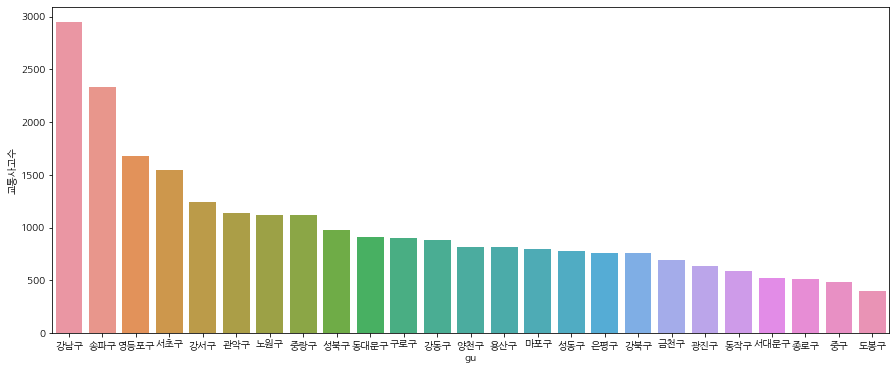

In [ ]:
plt.figure(figsize=(15, 6))
sns.barplot(data=accident_by_grid, x='gu', y='교통사고수')
plt.show()

- 구별 교통사고가 가장 많이 일어나는 곳이 강남구이고 $500m$ 격자별 교통사고 수 상위 5개 격자 또한 강남구에 몰려있었다. 따라서 강남구, 특히 교통사고 상위 5개 격자를 중점으로 분석하기로 하였다.

## 사고 0건 격자 시각화

In [ ]:
zero_acc_grid = geo_grids[geo_grids['교통사고수']==0]

In [ ]:
center = [37.566535, 126.9779692]
m = folium.Map(location=center,
               zoom_start=11,
               zoom_control=False,
               scrollWheelZoom=False,
               dragging=False,
               tiles='http://mt0.google.com/vt/lyrs=m&hl=ko&x={x}&y={y}&z={z}', 
               attr='Google')

c = folium.Choropleth(geo_data = zero_acc_grid,                                 # 위치 데이터
                      data=geo_grids[['gid', '교통사고수']],                  # 데이터
                      columns=['gid', '교통사고수'],
                      fill_color='RdYlBu',
                      key_on='properties.gid',                                # 격자번호 기준
                      highlight=True,
                      fill_opacity=0.6, 
                      line_opacity=0,
                      ).add_to(m)
c.geojson.add_child(folium.features.GeoJsonTooltip(['gid', '교통사고수']))  # 구역 이름 표시
m

- 교통사고가 한번도 일어나지 않은 격자들은 대부분 산, 대교가 없는 한강, 공원 등 도로가 없거나 차가 거의 다니지 않는 지역으로 보여진다.

# 데이터 분석

## 상위 5개 격자 교통사고 특성별 집계

### 요일과 주야간에 따른 사고건수 집계
- 주야간 구분
  - 주간:7시-17시, 야간:18시-6시

In [ ]:
top5_grid_names = top5_acc_grid['gid'].values
accident_match_grid = gpd.sjoin(geo_accident, geo_grids[['gid', 'geometry']], how='inner')
top5_accident = accident_match_grid[[gid in top5_grid_names for gid in accident_match_grid['gid']]].reset_index(drop=True)

In [ ]:
accident_day = top5_accident.groupby(['요일','주야간구분'], as_index = False).agg(count = ('주야간구분','count'))
accident_day = accident_day.sort_values('count', ascending = False)

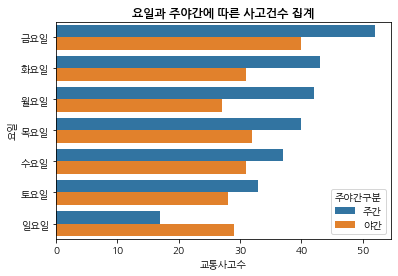

In [ ]:
sns.barplot(data=accident_day, y = '요일',x = 'count', hue = '주야간구분')
plt.title('요일과 주야간에 따른 사고건수 집계', fontweight='bold')
plt.xlabel('교통사고수')
plt.show()

- 금요일 주간에 가장 많은 사고가 일어나고 일요일 주간에 가장 사고가 적게 일어난다.
- 유동인구와 관련이 있을 것이라고 생각된다.

### 시간과 대상에 따른 사고건수 집계

In [ ]:
accident_time = top5_accident.groupby(['시간','대상'], as_index = False).agg(count = ('시간','count'))

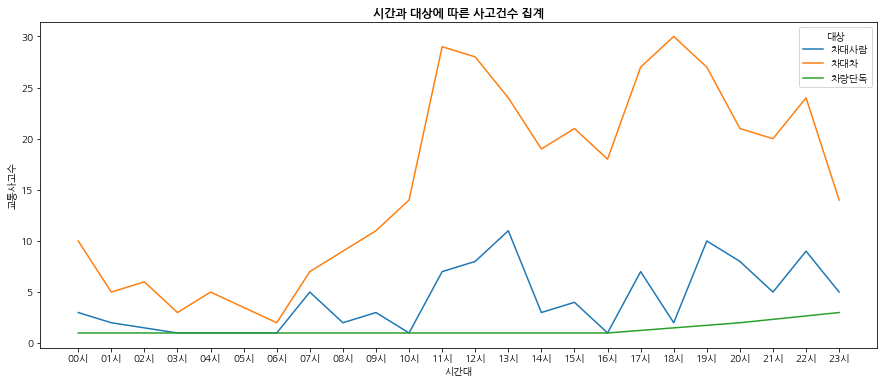

In [ ]:
fig = plt.figure(figsize=(15, 6))

accident_time_graph = sns.lineplot(data = accident_time, x = '시간', y='count', hue = '대상')
plt.title('시간과 대상에 따른 사고건수 집계', fontweight='bold')
plt.xlabel('시간대')
plt.ylabel('교통사고수')
plt.show()

### 사고경위에 따른 사고건수 집계

In [ ]:
accident_reason = top5_accident.groupby('사고경위', as_index = False).agg(count = ('사고경위','count'))
accident_reason = accident_reason.sort_values('count', ascending = False)

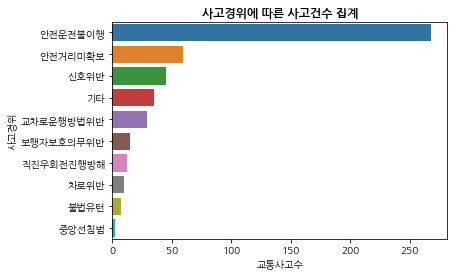

In [ ]:
sns.barplot(data=accident_reason, y = '사고경위',x = 'count')
plt.title('사고경위에 따른 사고건수 집계', fontweight='bold')
plt.xlabel('교통사고수')
plt.show()

### 사고유형별 사고건수 집계

In [ ]:
accident_type = top5_accident.groupby('사고유형', as_index = False).agg(count = ('사고유형','count'))
accident_type = accident_type.sort_values('count', ascending = False)

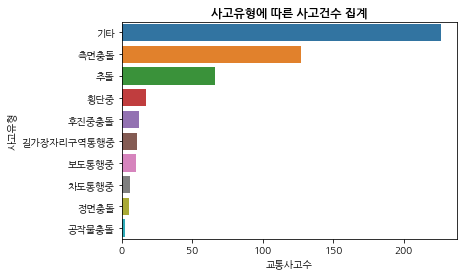

In [ ]:
sns.barplot(data=accident_type, y = '사고유형',x = 'count')
plt.title('사고유형에 따른 사고건수 집계', fontweight='bold')
plt.xlabel('교통사고수')
plt.show()

### 도로형태에 따른 사고건수 집계

In [ ]:
accident_road = top5_accident.groupby('도로형태', as_index = False).agg(count = ('도로형태','count'))
accident_road = accident_road.sort_values('count', ascending = False)

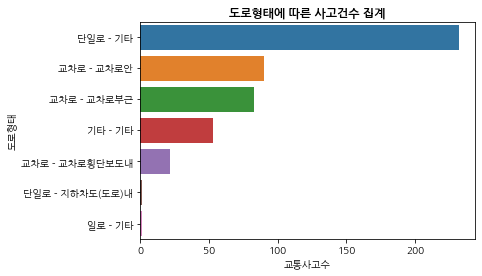

In [ ]:
sns.barplot(data=accident_road, y = '도로형태',x = 'count')
plt.title('도로형태에 따른 사고건수 집계', fontweight='bold')
plt.xlabel('교통사고수')
plt.show()

### 대상과 사고유형에 따른 사고건수 집계

In [ ]:
accident_target  = top5_accident.groupby(['대상','사고유형'], as_index = False).agg(count = ('사고유형','count'))

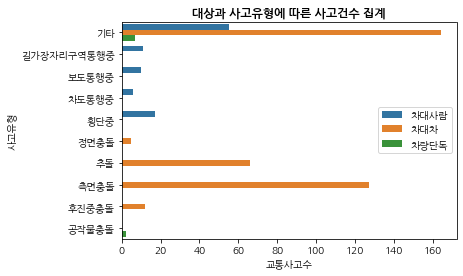

In [ ]:
sns.barplot(data=accident_target, y = '사고유형',x = 'count', hue = '대상')
plt.title('대상과 사고유형에 따른 사고건수 집계', fontweight='bold')
plt.legend(loc='center right')
plt.xlabel('교통사고수')
plt.show()

### 가해차종과 피해차종 분석

In [ ]:
car = top5_accident[['가해차종','피해차종']].copy()
car['가해차종'] = '가해 ' + car['가해차종'].astype(str)
car['피해차종'] = '피해 ' + car['피해차종'].astype(str)

car = car.rename(columns={'가해차종':'차종','피해차종':'차종'})
a_car = car.iloc[:,[0]]
b_car = car.iloc[:,[1]]

tmp = pd.concat([a_car,b_car], axis=0)
tmp['가해피해여부'] = tmp['차종'].apply( lambda x: x.split()[0] )
tmp['차종'] = tmp['차종'].apply( lambda x: x.split()[1] )
tmp = tmp.groupby(['차종','가해피해여부'], as_index = False).agg(count = ('차종','count'))

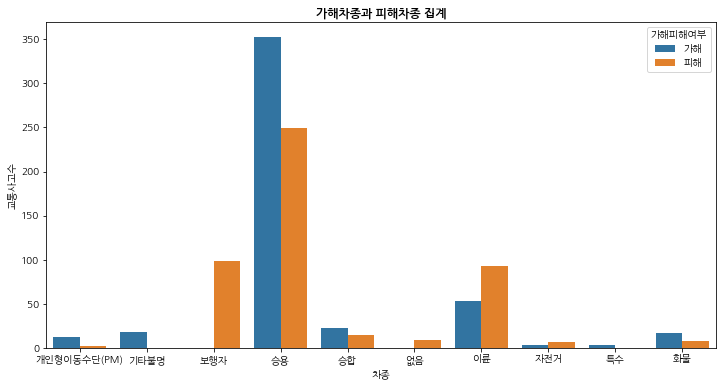

In [ ]:
fig = plt.figure(figsize=(12, 6))
sns.barplot(data=tmp, y = 'count',x = '차종', hue = '가해피해여부')
plt.title('가해차종과 피해차종 집계', fontweight='bold')
plt.ylabel('교통사고수')
plt.show()

## 교통사고 유형별 중대사고비율

- 사망사고의 빈도가 무의미할 정도로 적다
- 때문에 사망사고와 중상사고를 합쳐 중대사고로 정의한다
- 이를 전체 사고수로 나누어 중대사고비율을 계산하여 시각화한다

In [ ]:
def cri_aci(df):
  '''
    중대사고비율을 계산하고 중대사고비율을 새 컬럼으로 추가
  '''
  df['중상이상'] = df['사망사고']+df['중상사고']
  df['경상이하'] = df['경상사고']+df['부상신고사고']
  df['총사고수'] = df['중상이상']+df['경상이하']
  df['중대사고비율'] = df['중상이상']/df['총사고수']*100
  df['중대사고비율'] = df['중대사고비율'].round(2)
  df = df[['중상이상','경상이하','총사고수','중대사고비율']]

#### 사고경위에 따른 중대사고비율

In [ ]:
# top5지역 사고 경위에 따른 중대사고비율 계산
acci_pivot_top5 = top5_accident.pivot_table(values='gid', index='사고경위', columns='사고경중', aggfunc='count').replace(np.nan, 0)
cri_aci(acci_pivot_top5)
# 전체지역 사고 경위에 따른 중대사고비율 계산
acci_pivot_tot = accident.pivot_table(values='요일', index='사고경위', columns='사고경중', aggfunc='count').replace(np.nan, 0)
cri_aci(acci_pivot_tot)
# 중대사고비율만 모아서 새 DF 생성
acci_pivot_total = acci_pivot_top5[['중대사고비율']].copy()
acci_pivot_total.rename(columns={'중대사고비율':'TOP5지역 중대사고비율'}, inplace=True)
acci_pivot_total['전체 중대사고비율'] = acci_pivot_tot['중대사고비율']

<Figure size 720x1440 with 0 Axes>

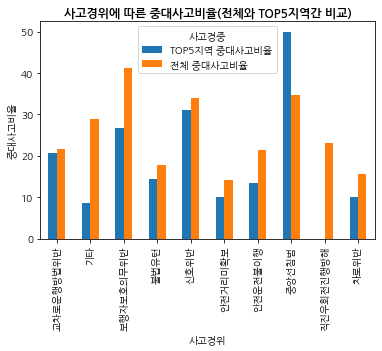

In [ ]:
# 새 DF로 바차트 생성
plt.figure(figsize=(10, 20))
acci_pivot_total.plot(kind='bar')
plt.title('사고경위에 따른 중대사고비율(전체와 TOP5지역간 비교)', fontweight='bold')
plt.ylabel('중대사고비율')
plt.show()

#### 노면상태에 따른 중대사고비율

In [ ]:
# top5지역 노면상태에 따른 중대사고비율 계산
acci_st_top5 = top5_accident.pivot_table(values='요일', index='노면상태', columns='사고경중', aggfunc='count').replace(np.nan, 0)
cri_aci(acci_st_top5)
acci_st_top5
# 전체지역 노면상태에 따른 중대사고비율 계산
acci_st_tot = accident.pivot_table(values='요일', index='노면상태', columns='사고경중', aggfunc='count').replace(np.nan, 0)
cri_aci(acci_st_tot)
acci_st_tot
# 중대사고비율만 모아서 새 DF 생성
acci_st_total = acci_st_top5[['중대사고비율']].copy()
acci_st_total.rename(columns={'중대사고비율':'TOP5지역 중대사고비율'}, inplace=True)
acci_st_total['전체 중대사고비율'] = acci_st_tot['중대사고비율']

<Figure size 720x720 with 0 Axes>

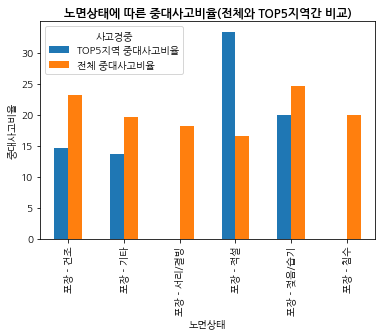

In [ ]:
# 새 DF로 바차트 생성
plt.figure(figsize=(10, 10))
acci_st_total.plot(kind='bar')
plt.title('노면상태에 따른 중대사고비율(전체와 TOP5지역간 비교)', fontweight='bold')
plt.ylabel('중대사고비율')
plt.show()

- 적설상태일 때 다른지역에 비해 중대사고비율이 늘어나는 경향

#### 사고대상에 따른 중대사고비율

In [ ]:
# top5지역 사고대상에 따른 중대사고비율
acci_obj_top5 = top5_accident.pivot_table(values='요일', index='대상', columns='사고경중', aggfunc='count').replace(np.nan, 0)
cri_aci(acci_obj_top5)

In [ ]:
# 전체지역 사고대상에 따른 중대사고비율
acci_obj_tot = accident.pivot_table(values='요일', index='대상', columns='사고경중', aggfunc='count').replace(np.nan, 0)
cri_aci(acci_obj_tot)

In [ ]:
acci_obj_total = acci_obj_top5[['중대사고비율']].copy()
acci_obj_total.rename(columns={'중대사고비율':'TOP5지역 중대사고비율'}, inplace=True)
acci_obj_total['전체 중대사고비율'] = acci_obj_tot['중대사고비율']

<Figure size 720x720 with 0 Axes>

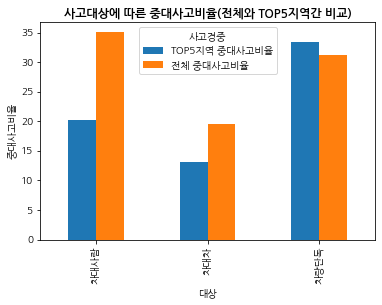

In [ ]:
plt.figure(figsize=(10, 10))
acci_obj_total.plot(kind='bar')
plt.title('사고대상에 따른 중대사고비율(전체와 TOP5지역간 비교)', fontweight='bold')
plt.ylabel('중대사고비율')
plt.show()

#### 사고유형에 따른 중대사고비율

In [ ]:
# top5지역 사고유형에 따른 중대사고비율
acci_res_top5 = top5_accident.pivot_table(values='요일', index='사고유형', columns='사고경중', aggfunc='count').replace(np.nan, 0)
cri_aci(acci_res_top5)

In [ ]:
# 전체지역 사고유형에 따른 중대사고비율
acci_res_tot = accident.pivot_table(values='요일', index='사고유형', columns='사고경중', aggfunc='count').replace(np.nan, 0)
cri_aci(acci_res_tot)

In [ ]:
acci_res_total = acci_res_top5[['중대사고비율']].copy()
acci_res_total.rename(columns={'중대사고비율':'TOP5지역 중대사고비율'}, inplace=True)
acci_res_total['전체 중대사고비율'] = acci_res_tot['중대사고비율']

<Figure size 720x720 with 0 Axes>

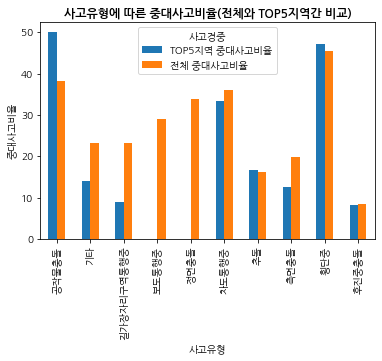

In [ ]:
plt.figure(figsize=(10, 10))
acci_res_total.plot(kind='bar')
plt.title('사고유형에 따른 중대사고비율(전체와 TOP5지역간 비교)', fontweight='bold')
plt.ylabel('중대사고비율')
plt.show()

#### 요일에 따른 중대사고비율

In [ ]:
# top5지역 요일에 따른 중대사고비율
acci_day_top5 = top5_accident.pivot_table(values='사고유형', index='요일', columns='사고경중', aggfunc='count').replace(np.nan, 0)
cri_aci(acci_day_top5)

In [ ]:
# 전체지역 요일에 따른 중대사고비율
acci_day_tot = accident.pivot_table(values='사고유형', index='요일', columns='사고경중', aggfunc='count').replace(np.nan, 0)
cri_aci(acci_day_tot)

In [ ]:
acci_day_total = acci_day_top5[['중대사고비율']].copy()
acci_day_total.rename(columns={'중대사고비율':'TOP5지역 중대사고비율'}, inplace=True)
acci_day_total['전체 중대사고비율'] = acci_day_tot['중대사고비율']

<Figure size 720x720 with 0 Axes>

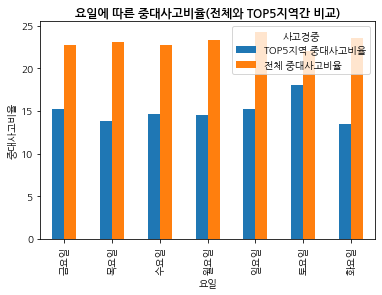

In [ ]:
plt.figure(figsize=(10, 10))
acci_day_total.plot(kind='bar')
plt.title('요일에 따른 중대사고비율(전체와 TOP5지역간 비교)', fontweight='bold')
plt.ylabel('중대사고비율')
plt.show()

- 요일은 전체적으로 중대사고비율이 고르게 분포하고 있음

## 교통사고 다발/미발 격자 비교

In [ ]:
zero_feature = zero_acc_grid.mean(numeric_only=True)
top5_feature = top5_acc_grid.mean(numeric_only=True)

In [ ]:
top_zero = pd.DataFrame(index=zero_feature.index, columns=['top5','zero'])
top_zero['top5'] = top5_feature.values
top_zero['zero'] = zero_feature.values
melt_df = top_zero.reset_index().melt('index')
melt_df = melt_df[melt_df['index'] != '교통사고수']

### 도로면적, 총인구수 비교

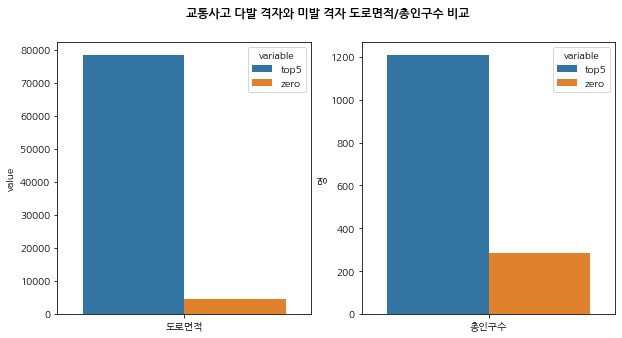

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
fig.suptitle('교통사고 다발 격자와 미발 격자 도로면적/총인구수 비교',fontweight ="bold")

sns.barplot(data=melt_df[melt_df['index'] == '도로면적'], x='index', y='value', hue='variable', ax=ax[0])
ax[0].set_xlabel('')
plt.ylabel('m2')

sns.barplot(data=melt_df[melt_df['index'] == '총인구수'], x='index', y='value', hue='variable', ax=ax[1])
ax[1].set_xlabel('')
plt.ylabel('명')
plt.show()

### 주변시설물, 교통시설물, 상권 비교

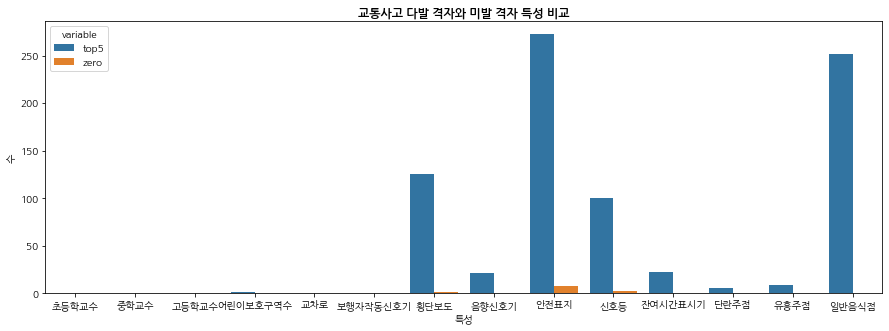

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(data=melt_df[[not idx in ['총인구수', '도로면적'] for idx in melt_df['index']]], x='index', y='value', hue='variable')
plt.xlabel('특성')
plt.ylabel('수')
plt.title('교통사고 다발 격자와 미발 격자 특성 비교', fontweight ="bold")
plt.show()

- 교통사고 미발 격자는 대체적으로 차가 다니는 도로가 없는 것이 일반적이다. 따라서 교통사고 상위 5개 격자가 속한 강남구 내에서 비교하기로 하였다.

## 강남구 내 격자 분석

In [ ]:
gangnam_grid = geo_grids[geo_grids['gu'].str.contains('강남구')]

In [ ]:
center = [37.4930308, 127.0656148]
m = folium.Map(location=center, 
               zoom_start=13,
               zoom_control=False,
               scrollWheelZoom=False,
               dragging=False,
               tiles='http://mt0.google.com/vt/lyrs=m&hl=ko&x={x}&y={y}&z={z}', 
               attr='Google')

c = folium.Choropleth(geo_data = gangnam_grid,
                      data=geo_grids[['gid', '교통사고수']],                 
                      columns=['gid', '교통사고수'],
                      fill_color='RdPu',
                      key_on='properties.gid',                              
                      highlight=True,
                      fill_opacity=0.8, 
                      line_opacity=0.1,
                      legend_name='교통사고수'   
                      ).add_to(m)
c.geojson.add_child(folium.features.GeoJsonTooltip(['gid', '교통사고수']))  
m

- 강남구 또한 도로가 없는 지역이 포함되어있어 특성을 비교하기 어렵다. 따라서 강남구에서 도로면적이 교통사고 다발 격자와 비슷한 격자들만 비교하기로 하였다.

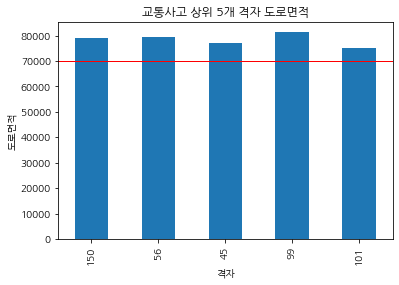

In [ ]:
top5_acc_grid = geo_grids.sort_values(by='교통사고수', ascending=False).head(5)
top5_acc_grid['도로면적'].plot.bar()

plt.axhline(y=70000, color='r', linewidth=1)
plt.xlabel('격자')
plt.ylabel('도로면적')
plt.title('교통사고 상위 5개 격자 도로면적')

plt.show()

- 상위 5개 격자 모두 도로면적이 70,000 이상이다. 따라서 강남구 격자 중 도로면적이 70,000 이상인 격자들만 추출하여 비교해보기로 하였다.

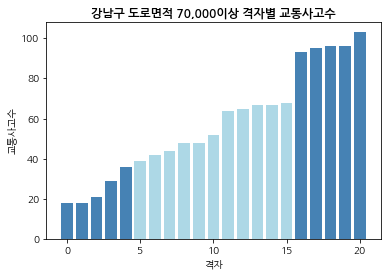

In [ ]:
gangnam_wide_road_grid = gangnam_grid[gangnam_grid['도로면적'] > 70000].sort_values(by='교통사고수').reset_index(drop=True)

plt.bar(data=gangnam_wide_road_grid, x=gangnam_wide_road_grid.index, height='교통사고수', color=['steelblue']*5+['lightblue']*11)
plt.xlabel('격자')
plt.ylabel('교통사고수')
plt.title('강남구 도로면적 70,000이상 격자별 교통사고수', fontweight='bold')

plt.show()

- 같은 강남구에 속하고 도로면적이 70,000이상임에도 교통사고 수에 차이가 있음을 확인했다. 해당하는 격자에서 상위 5개(서울시 교통사고 상위 5개 격자와 동일)와 하위 5개 격자를 비교하기로 하였다.

## 강남구 교통사고 상위/하위 5개 격자 비교

In [ ]:
low_road_wide_gangnam = gangnam_wide_road_grid.head(5)

In [ ]:
center = [37.5030308, 127.0416148]
m = folium.Map(location=center, 
               zoom_start=13,
               zoom_control=False,
               scrollWheelZoom=False,
               dragging=False,
               tiles='http://mt0.google.com/vt/lyrs=m&hl=ko&x={x}&y={y}&z={z}', 
               attr='Google')

c = folium.Choropleth(geo_data = low_road_wide_gangnam,
                      data=geo_grids[['gid', '교통사고수']],                 
                      columns=['gid', '교통사고수'],
                      fill_color='RdPu',
                      key_on='properties.gid',                              
                      highlight=True,
                      fill_opacity=0.8, 
                      line_opacity=1,
                      legend_name='교통사고수'   
                      ).add_to(m)
c.geojson.add_child(folium.features.GeoJsonTooltip(['gid', '교통사고수']))  
m

In [ ]:
top_low_gangnam = pd.DataFrame(index=top5_feature.index, columns=['top5','low'])
top_low_gangnam['top5'] = top5_feature.values
top_low_gangnam['low'] = low_road_wide_gangnam.mean(numeric_only=True).values
melt_df = top_low_gangnam.reset_index().melt('index')
melt_df = melt_df[melt_df['index'] != '교통사고수']

### 도로면적, 총인구수 비교

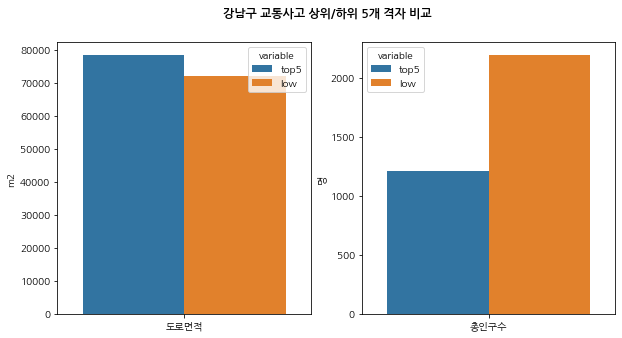

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
fig.suptitle('강남구 교통사고 상위/하위 5개 격자 비교',fontweight ="bold")

sns.barplot(data=melt_df[melt_df['index'] == '도로면적'], x='index', y='value', hue='variable', ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_ylabel('m2')

sns.barplot(data=melt_df[melt_df['index'] == '총인구수'], x='index', y='value', hue='variable', ax=ax[1])
ax[1].set_xlabel('')
ax[1].set_ylabel('명')

plt.show()

### 주변시설물, 교통시설물, 상권 비교

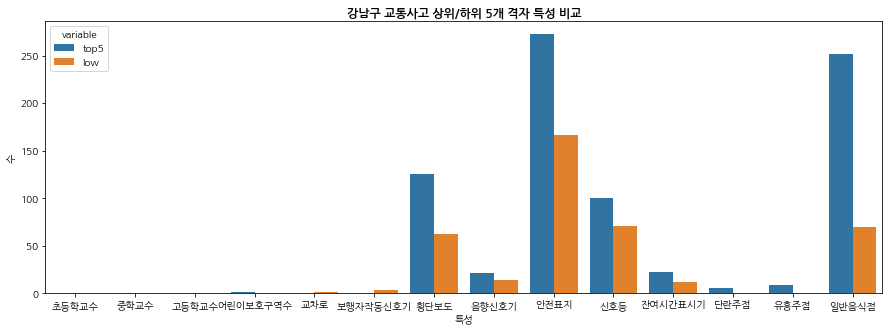

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(data=melt_df[[not idx in ['총인구수', '도로면적'] for idx in melt_df['index']]], x='index', y='value', hue='variable')
plt.xlabel('특성')
plt.ylabel('수')
plt.title('강남구 교통사고 상위/하위 5개 격자 특성 비교', fontweight ="bold")
plt.show()

### 상관관계 시각화

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


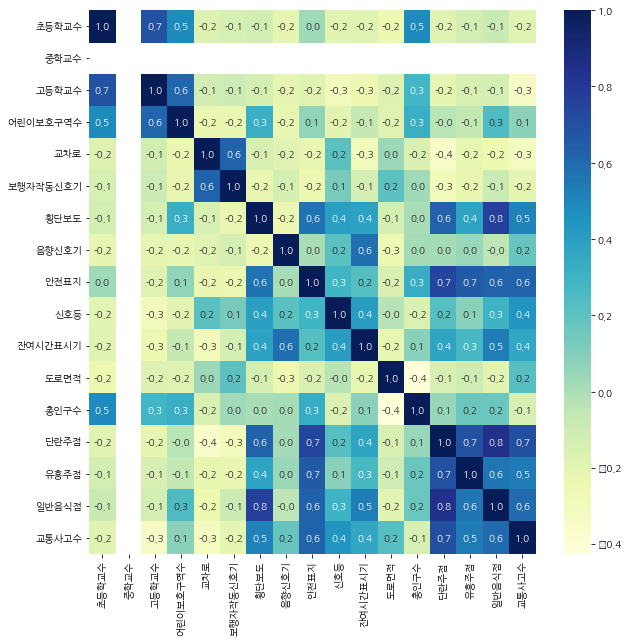

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(gangnam_wide_road_grid.drop(columns=['gid', 'geometry', 'gu']).corr(),
            annot=True,
            fmt=".1f",
            cmap='YlGnBu')
plt.show()

- 위의 상관관계 표는 도로면적이 $70,000m^2$ 이상인 강남구 격자만을 기준으로 한 상관관계이다.

# 분석 결과

교통사고 다발지역에 대해서

- 전체적인 교통사고 수는 학교 수와 크게 연관이 없어보인다.
- 교통사고 수가 많은 곳은 교통시설물의 수(안전 관련 시설물 포함) 또한 많다.
- 주점, 음식점이 많은 번화가일수록 사고가 더 많이 일어난다.

## 차대차 위험지역

- 사거리 주변 도로의 사고가 많다.

In [ ]:
top5_accident[top5_accident['대상']=='차대차'].explore(tiles='http://mt0.google.com/vt/lyrs=m&hl=ko&x={x}&y={y}&z={z}', 
               attr='Google', color='red')

## 차대사람 위험지역

- 골목길 내에서의 사고가 많다.

In [ ]:
top5_accident[top5_accident['대상']=='차대사람'].explore(tiles='http://mt0.google.com/vt/lyrs=m&hl=ko&x={x}&y={y}&z={z}', 
               attr='Google', color='red')